In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from lisflood_read_plot import *

from reservoirs_lshm.utils.plots import plot_resops, reservoir_analysis

## Config

In [2]:
PATH_TESTS = Path('Z:/nahaUsers/casadje/GloFASv5/reservoirs/tests')

In [17]:
catchment = '4814'
test = 'out_Gv5test5_deapup_MCT_TL_RES'
PATH_RESULTS = PATH_TESTS / catchment / test

In [18]:
# PATH_OBS = Path('Z:/nahaUsers/casadje/datasets/Kazakhstan/reservoirs/timeseries/processed')

## Records

In [19]:
# observed = pd.read_csv(PATH_OBS / 'shardara.csv', parse_dates=True, index_col='date')
# observed.rename(columns={'inflow m3/sec': 'inflow', 'discharge m3/sec': 'outflow', 'volume million/m3': 'filling'}, inplace=True)
# observed.filling /= 6700 # 5200 hm3 according to Kazakhstan

# observed.head()

## Model

### Time series

In [20]:
try:
    settings_file = list(PATH_RESULTS.glob('*.xml'))[0]
except:
    settings_file = None


fill = read_tss(
    tss=PATH_RESULTS / 'resfill.tss',
    xml=settings_file
)
fill = fill.replace(1e31, np.nan).dropna(axis=1, how='all')
fill.columns = fill.columns.astype(int)

qin = read_tss(
    tss=PATH_RESULTS / 'qresin.tss',
    xml=settings_file
)
qin = qin.replace(1e31, np.nan).dropna(axis=1, how='all')
qin.columns = qin.columns.astype(int)

qout = read_tss(
    tss=PATH_RESULTS / 'qresout.tss',
    xml=settings_file
)
qout = qout.replace(1e31, np.nan).dropna(axis=1, how='all')
qout.columns= qout.columns.astype(int)

In [21]:
fill.head()

,482,1642
timestep,,
1463,0.662298,0.655557
1464,0.697266,0.645481
1465,0.698859,0.617497
1466,0.686556,0.589705
1467,0.671051,0.565352


### Reservoir attributes

In [22]:
attributes = []
for txt_file in (PATH_TESTS  / 'tables' / 'old').glob('reservoirs*.txt'):
    if len(txt_file.stem.split('_')) == 5:
        continue
    print(txt_file)
    attr = pd.read_csv(txt_file, sep='\t', header=None, index_col=0)
    attr.columns = ['_'.join(txt_file.stem.split('_')[2:])]
    attr.index.name = 'ID'
    attributes.append(attr)
attributes = pd.concat(attributes, axis=1)
attributes = attributes.loc[fill.columns]

attributes.head()

Z:\nahaUsers\casadje\GloFASv5\reservoirs\tests\tables\old\reservoirs_glofas5_100yr_inflow.txt
Z:\nahaUsers\casadje\GloFASv5\reservoirs\tests\tables\old\reservoirs_glofas5_avg_inflow.txt
Z:\nahaUsers\casadje\GloFASv5\reservoirs\tests\tables\old\reservoirs_glofas5_capacity.txt
Z:\nahaUsers\casadje\GloFASv5\reservoirs\tests\tables\old\reservoirs_glofas5_env_flow.txt


,100yr_inflow,avg_inflow,capacity,env_flow
482,8587.1,135.4,3140000000,6.769
1642,1943.2,30.2,278300000,1.512


### Reservoir parameters

In [23]:
parameters = pd.DataFrame(index=attributes.index)
parameters['flood_storage'] = 0.75
parameters['outflow_factor'] = 0.3

parameters.head()

,flood_storage,outflow_factor
482,0.75,0.3
1642,0.75,0.3


### Reservoir limits

In [24]:
limits = pd.DataFrame(index=attributes.index, dtype=float)

limits['Vt'] = 1 # attributes.capacity
limits['Ve'] = 0.8 * limits.Vt + 0.2 * parameters.flood_storage
limits['Vf'] = parameters.flood_storage * limits.Vt
limits['Vc'] = 0.5 * limits.Vf

limits['Qf'] = parameters.outflow_factor *  attributes['100yr_inflow']
limits['Qn'] = attributes.avg_inflow
limits['Qc'] = limits.Qn * limits.Vc / limits.Vf
limits['Qmin'] = attributes.env_flow

limits.head()

,Vt,Ve,Vf,Vc,Qf,Qn,Qc,Qmin
482,1,0.95,0.75,0.375,2576.13,135.4,67.7,6.769
1642,1,0.95,0.75,0.375,582.96,30.2,15.1,1.512


### Analysis

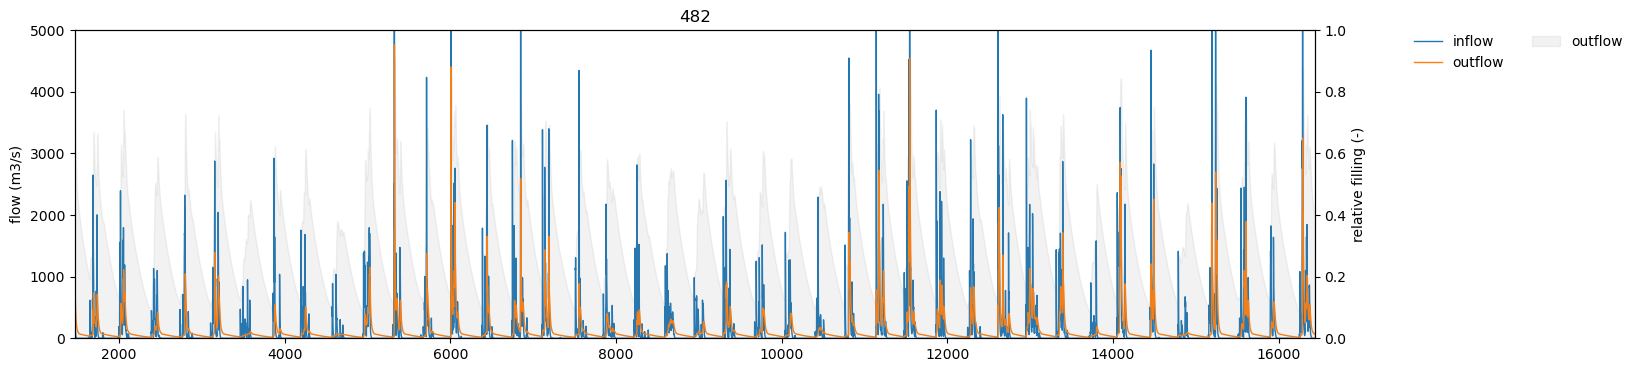

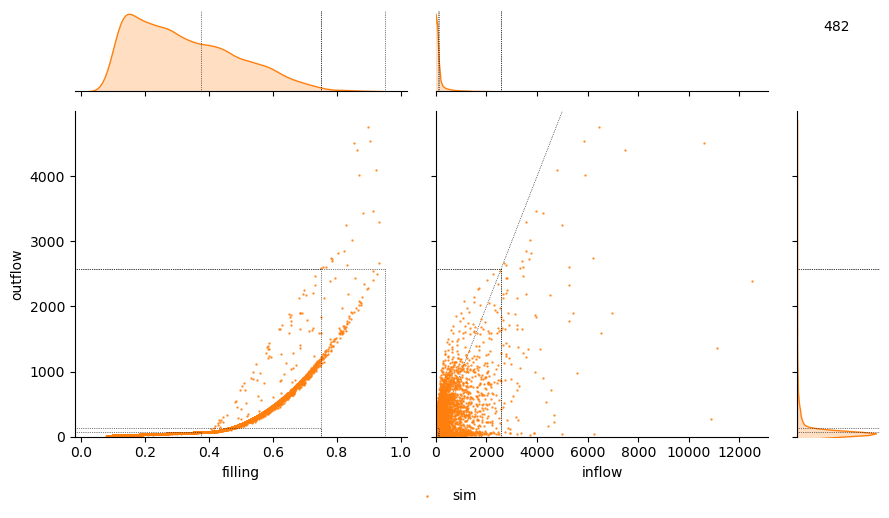

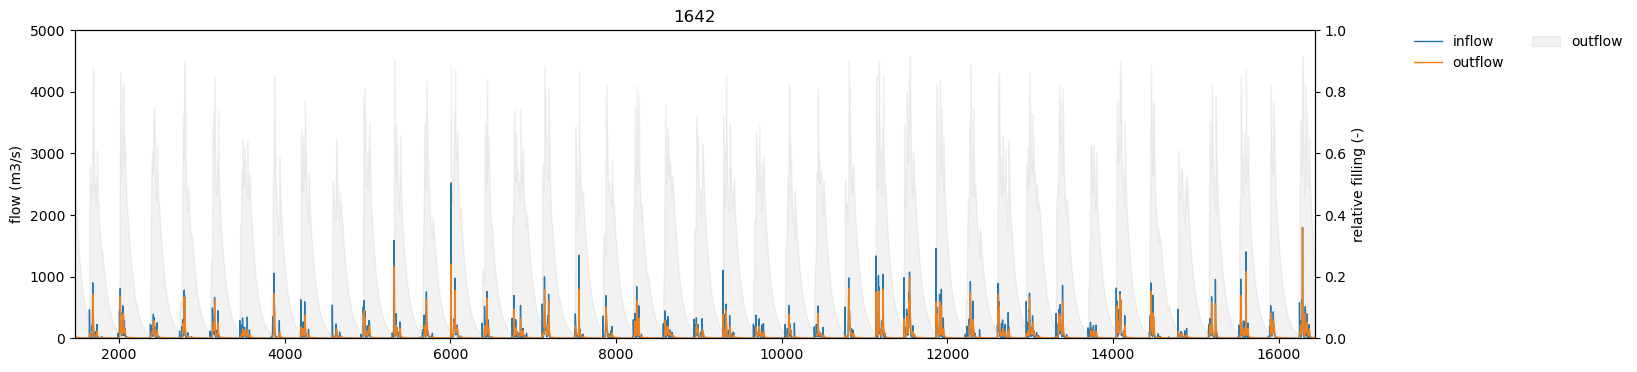

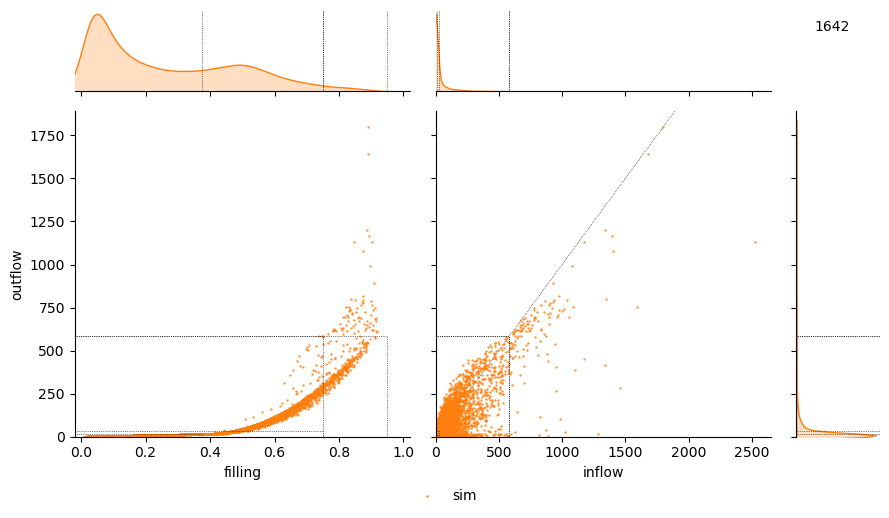

In [27]:
for ID in fill.columns:
    sim = pd.concat((fill[ID], qin[ID], qout[ID]), axis=1)
    sim.columns = ['filling', 'inflow', 'outflow']
    plot_reservoir(sim, title=ID)
    if ID == 525:
        obs = observed
    else:
        obs = None
    reservoir_analysis(
        sim=sim,
        obs=obs,
        x1='filling',
        x_thr=limits.loc[ID, ['Ve', 'Vf', 'Vf', 'Vc']],
        x2='inflow',
        y='outflow',
        y_thr=limits.loc[ID, ['Qf', 'Qf', 'Qn', 'Qc']],
        title=ID,
        alpha=.8
    )

In [26]:
5

5